# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Maggy

Last Name: Ryan

Student ID: 998037677

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [2]:
import sqlite3
conn = sqlite3.connect('sf_data.sqlite')

# This allows the commands to be executed in python using an SQL database as the source.
c = conn.cursor()
freq = c.execute('select permit,count(*) as frequency from mobile_food_schedule group by permit order by count(*) desc')

# We'll start by gathering (fetching) all of the permit numbers into a list. We gather now many locations were granted to each permit.
# The list created is a list of permits ordered by the number of locations granted in descending order.

i = 0
frequencyList = freq.fetchall()

"""
We loop through each permit number gathered above.
If the number matches a food truck vendor from the database, then we search whether that permit was approved.
While there may be mobile food vendors that had more permit locations, we weren't interested in the vendors that were not approved.
The while loop will return the name of the food vendor that has the highest number of approved locations.
"""
while(True):
    c.execute('select * from mobile_food_permits where permit like \'' +frequencyList[i][0] + '\'')
    truckData = c.fetchone()
    if(truckData[1] == 'APPROVED'):
        print(truckData[2])

        if(frequencyList[i][1] > frequencyList[i+1][1]):
            break
    i += 1


Park's Catering


__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

Lowest price zip code: 94124
Highest price zip code: 94104

Lowest zipcode intersects:
Potrero Hill
Central Waterfront
Peralta Heights
India Basin
Hunters Point
Candlestick Point SRA
Apparel City
Bernal Heights
Produce Market
Bayview
Silver Terrace
Bret Harte
Little Hollywood
Portola

Highest zipcode intersects:
Downtown / Union Square
Chinatown
Financial District


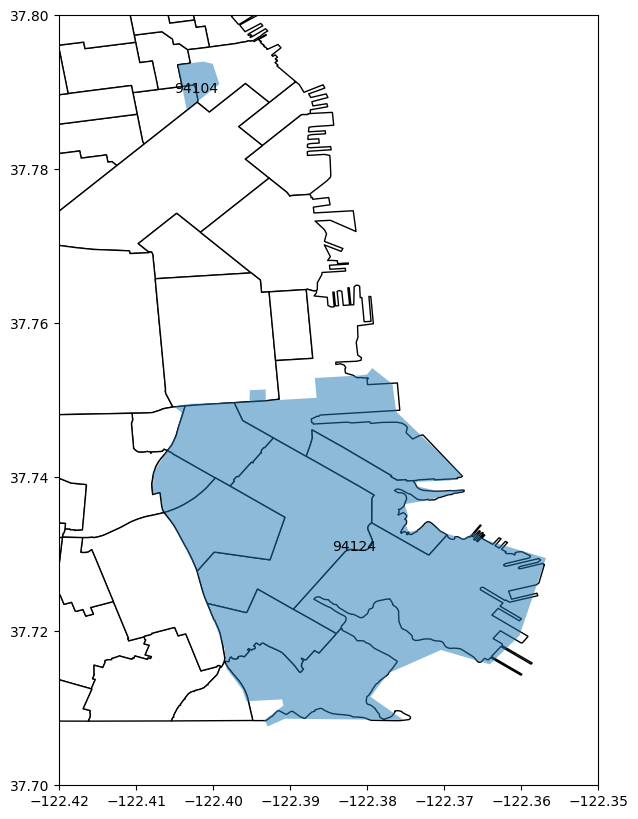

In [85]:
# Question 1: Which parts of the city are most and least expensive?


import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd
import osmnx as ox
import shapely.geometry as geom


# Reading the shape file for the zipcodes
locationDir = 'cb_2016_us_zcta510_500k/'
locationShapefile = 'cb_2016_us_zcta510_500k.shp'
locations = gpd.read_file(locationDir + locationShapefile)

# Reading the shape file for the SF neighborhoods
neighborhoodDir = 'SF Find Neighborhoods/'
neighborhoodShapefile = 'geo_export_e8fa5576-54e1-41db-a695-5cf4163442e4.shp'
neighborhoods = gpd.read_file(neighborhoodDir + neighborhoodShapefile)

# This extracts the least expensive zipcode from the SQL database
c.execute('select RegionName, min(MedianSoldPricePerSqft_AllHomes) from zillow;')
lowestPrice = str(c.fetchone()[0])
print('Lowest price zip code: ' + lowestPrice)

# This extracts the most expensive zipcode from the SQL database
c.execute('select RegionName, max(MedianSoldPricePerSqft_AllHomes) from zillow;')
highestPrice = str(c.fetchone()[0])
print('Highest price zip code: ' + highestPrice)

lowestZip = locations[locations.ZCTA5CE10 == lowestPrice]
highestZip = locations[locations.ZCTA5CE10 == highestPrice]

# This merges the most and least expensive zipcodes into a single variable
combinedZip = lowestZip.append(highestZip)

# If the neighborhood intersects the least expensive zipcode, we color it in.
print('\nLowest zipcode intersects:')
for neighborhood in neighborhoods.iterrows():
    if(lowestZip.geometry.intersects(neighborhood[1][2]).iloc[0]):
        print(neighborhood[1][1])

# If the neighborhood intersects the most expensive zipcode, we color it in.
print('\nHighest zipcode intersects:')
for neighborhood in neighborhoods.iterrows():
    if(highestZip.geometry.intersects(neighborhood[1][2]).iloc[0]):
        print(neighborhood[1][1])    
        
# This overlays the zipcode with the area colored in
def add_zip_label(row):
    coords = row.geometry.representative_point().coords[0]
    zipPlot.annotate(row.ZCTA5CE10, xy = coords, horizontalalignment = "center")
    
ax = neighborhoods.plot(color='white',edgecolor='black',figsize=(10,10))

# Setting the boundareis for the map
ax.set_xlim([-122.42, -122.35])
ax.set_ylim([37.7, 37.8])

# Plotting the image
zipPlot = combinedZip.plot(ax = ax,alpha=0.5,figsize=(1,1))
combinedZip.apply(add_zip_label, axis = 1)
plt.show()

# Unsurprisingly, the most expensive zip code is centered around the downtown area.
# Since this is the center of activity, it would make sense that this would be the most expensive region.
# Looking at the map, the overlap between the highest price zip code and one of the intersecting neighborhoods (Chinatown) is negligible.
# This may mean that Chinatown as a whole doesn't fall into the "most expensive" category, but that a small portion is because of its proximity to downtown.
# The lowest price zipcode intersects encompases many more neighborhoods than the highest price.
# This may be because the housing in these areas is much more spread out (the population is much less dense than the high priced areas).
# These areas of the city may also be far removed from activity which would drive housing prices down.
# The lowest zipcode also is on the border of San Francisco, which could be responsible for these prices.
# I would hypothesize that the general trend of housing prices would show that they decrease the farther away from downtown you go.

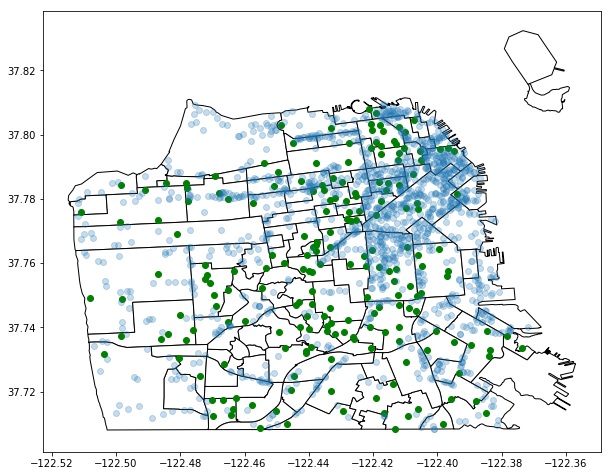

In [75]:
# Question 2: Is there any connection between the location of the parks and parking lots in San Francisco?

# This extracts the coordinates of the park locations
c.execute('select Name,Lat,Lon from parks where Lat is not NULL and Lon is not NULL;')
parksLatLon = c.fetchall()

# Breaking up the result category (i.e. name, latatite, longiture).
# All points that fall outside of the range of San Francisco are taken out.
parksLatLon = [i for i in parksLatLon if i[2] <= -122 and i[1] > 37.7]
parkNames = [n[0] for n in parksLatLon]
parkLats = [n[1] for n in parksLatLon]
parkLons = [n[2] for n in parksLatLon]

# This creates locations of parks based on the coordinates extracted above.
parkPoints = [geom.Point(x) for x in zip(parkLons, parkLats)]
parkFrame = gpd.GeoDataFrame(parkNames,columns=['name'],geometry = parkPoints)


# This extracts the coordinates of the parking lot locations
c.execute('select Address,Lat,Lon from parking where Lat is not NULL and Lon is not NULL;')
parkingLatLon = c.fetchall()

# Breaking up the result category (i.e. address, latatite, longiture).
# All points that fall outside of the range of San Francisco are taken out.
parkingAddresses = [n[0] for n in parkingLatLon]
parkingLats = [n[1] for n in parkingLatLon]
parkingLons = [n[2] for n in parkingLatLon]

# This creates locations of parking lots based on the coordinates extracted above.
parkingPoints = [geom.Point(x) for x in zip(parkingLons, parkingLats)]
parkingFrame = gpd.GeoDataFrame(parkingAddresses,columns=['address'],geometry = parkingPoints)
neighborhoodParks = neighborhoods.copy()

# Plotting the parks and parking lots on a map of San Francisco
ax = neighborhoodParks.plot(color='white',edgecolor='black',figsize=(10,10))
ax2 = parkFrame.plot(ax=ax,figsize=(10,10),color='green')
parkingFrame.plot(ax=ax2,figsize=(10,10),alpha=0.25)

plt.show()

# It is immediately obvious that parking lot locations (blue) are dense in the downtown area.
# This is unsurprising as this is where a lot of activity in San Francisco happens (i.e. shopping, bars, offices and other businesses).
# Interestingly, the occurances of parks (shown in green) are also heavy in the downtown area.
# This could be because there are a lot of small schools in the downtown San Francisco area leading to playgrounds for the kids who attend.
# I noticed that there appears to be a slight relation between park and parking lot locations.
# Areas that have more parking lots also have more parks, and areas with fewer parking lots also have fewer parks.
# With only a few exceptions, parks generally have a parking lot close to them.
# This makes sense as people will need a place to park their vehicle while enjoying the park.
# I would hypothesize that the parks farther from parking lot locations would be less busy that parks that are close to several parking lots.

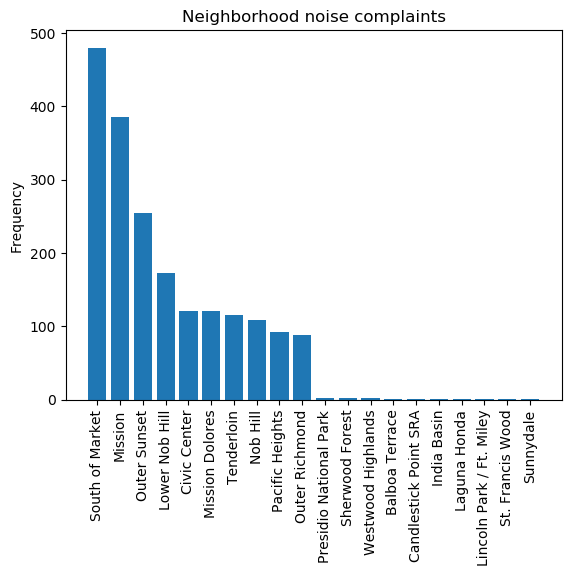

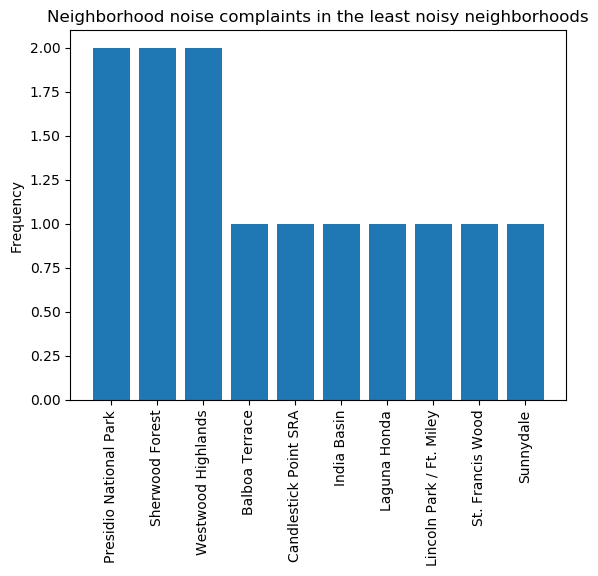

In [80]:
# Question 3: Which neighborhoods are the noisiest and quietest?

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

# This counts the number of times that each neighborhood appears in the list of noise complaints.
freq = c.execute('select Neighborhood,count(*) as frequency from noise group by Neighborhood order by count(*) desc')
noiseList = freq.fetchall()
del noiseList[0]

# This extracts the top 10 noisiest neighborhoods
noiseListTopBottom = noiseList[:10]

# This extracts the 10 least noisy neighborhoods
noiseListTopBottom.extend(noiseList[-10:])
neighborhoodNoiseList = [i[0] for i in noiseListTopBottom]
neighborhoodNoiseCount = [i[1] for i in noiseListTopBottom]

# Combining them in one graph
y_pos = np.arange(len(neighborhoodNoiseList))
plt.bar(y_pos, neighborhoodNoiseCount, align = 'center')
plt.xticks(y_pos,neighborhoodNoiseList,rotation='vertical')
plt.ylabel('Frequency')
plt.title("Neighborhood noise complaints")

plt.show()

# Showing just the 10 least noisy neighborhoods

y_pos = np.arange(len(neighborhoodNoiseList[-10:]))
plt.bar(y_pos, neighborhoodNoiseCount[-10:], align = 'center')
plt.xticks(y_pos,neighborhoodNoiseList[-10:],rotation='vertical')
plt.ylabel('Frequency')
plt.title("Neighborhood noise complaints in the least noisy neighborhoods")

plt.show()
# Noise complaints were used as a measure of how loud or quiest a neighborhood is.
# In general,the noisiest neighborhoods tend to be in higher traffic areas.
# This is unsurpsing as more people would lead to more of a chance of noise complaints.
# Additionally, downtown areas that have a lot of active nightlife would make sense as having more noise complaints than residential neighborhoods.
# With the exception of outer sunset, the noisiest neighborhoods tend to be clustered around downtown.
# This makes sense as downtown San Francisco tends to be busy even at night.
# The least noisy neighborhoods tend to be in lower foot traffic areas.
# The trend with the least noisy areas is that they tend to be in primarily residental areas.
# Therefore, there isn't a reason for people to be spending time there at night unless they live there.
# This concept can be applied to high-noise areas too, where people are likely to be in that area of San Francisco even if they don't live there.

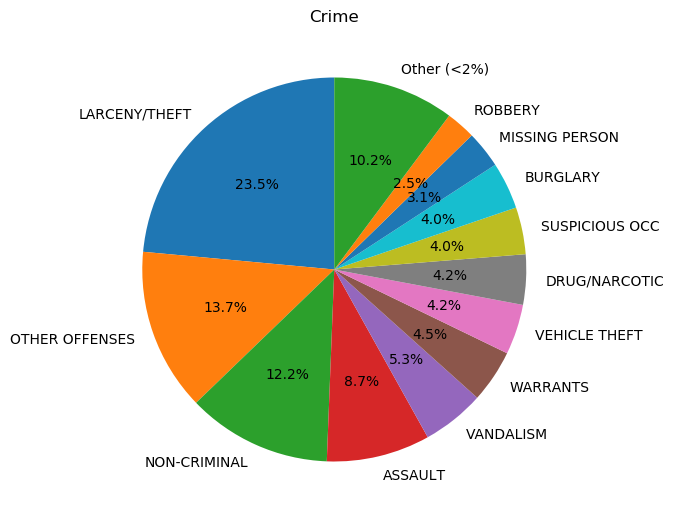

In [91]:
# Question 4: What day of the week are the most crimes committed?

# First, we extract the data on the type of crime committed
freq = c.execute('select Category,count(*) as frequency from crime group by Category order by count(*) desc')
crimeCategoryList = freq.fetchall()

crimeCategories = [i[0] for i in crimeCategoryList]
crimeCategoriesCount = [i[1] for i in crimeCategoryList]

# Because there are so many catories, crimes catories that made up less than 2% of all crime was labeled as "other".
cutoff = 12
lowerCrimeCount = sum(crimeCategoriesCount[cutoff:])
crimeCategoriesCount = crimeCategoriesCount[:cutoff]
crimeCategoriesCount.append(lowerCrimeCount)
crimeCategories = crimeCategories[:cutoff]
crimeCategories.append('Other (<2%)')

# Creating the pie chart
plt.figure(1, figsize=(6,6))
plt.ax = plt.axes([0.9, 0.1, 0.8, 0.8])
plt.pie(crimeCategoriesCount,labels=crimeCategories,autopct='%1.1f%%',startangle=90)
plt.title('Crime')
plt.show()

# The most common type of crime by far is larceny/theft. Given the dense population of San Francisco and the distribution of wealth, this should not be surprising.
# Violent crime (such as assault and robbery) makes up an incredibly small portion of total crime. This is good as crimes that involve a victim are relatively uncommon compared to those that do not involve another person.
# Surprisingly, criminal activity related to warrents is much more common than other crimes.
# About 1/8 of the crimes reported is listed as "non-criminal".
# Assuming that this refers to times that the police were called but no crime was committed, a surprising number of calls may have been either misdialed or people should have called the non-emergency police line.
# It would be interesting to know what classifies as "other offenses" and if the cutoff for "other offenses" was based on a portion of total crime.

['Mo', 'Fr', 'We', 'Th', 'Tu', 'Sa', 'Su']
[736, 651, 643, 638, 635, 160, 129]


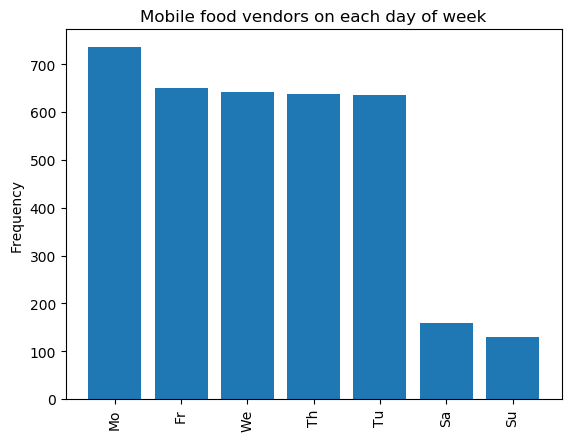

In [56]:
# Question 5: Which days of the week are most popular to request food vendors to be scheduled?

# First, we extract the frequency of mobile food vendors based on day of the week
freq = c.execute('select DayOfWeek,count(*) as frequency from mobile_food_schedule group by DayOfWeek order by count(*) desc')
dayList = freq.fetchall()
dayList

days = [i[0] for i in dayList]
dayCount = [i[1] for i in dayList]


print(days)
print(dayCount)

# Plotting the results of the frequency of permit requests each day of the week in descending order.
y_pos = np.arange(len(days))
plt.bar(y_pos, dayCount, align = 'center')
plt.xticks(y_pos,days,rotation='vertical')
plt.ylabel('Frequency')
plt.title("Mobile food vendors on each day of week")

plt.show()

# Interestingly, the weekends are the least common days for food vendors to be scheduled.
# While Friday, Wednesday, Thursday, and Tuesday are have realatively similar request numbers, Monday is noticably higher.
# Vendor permit requests may be more popular during the week as people who work in the city are likely to use a mobile food vendor to get a quick lunch.
# There also may be more competition between food vendors for the people who eat at mobile food vendor locations on the weekend, leading some to not schedule the weekend as the cost-profit margin makes it a not economically smart option.
# I hypothesize that food vendors are less popular during the weekend as people are more likely to eat out at a sit-down restaurant, and thus weekends are less profitable.
# Monday may be the most popular day as workers are more likely to want to treat themselves to a meal out for lunch at the beginning of the week.

In [ ]:
# Sources used:
# https://docs.python.org/2/library/sqlite3.html#sqlite3.Connection
# https://stackoverflow.com/questions/1217244/select-top-distinct-results-ordered-by-frequency
# https://pypi.python.org/pypi/pyshp
# https://stackoverflow.com/questions/31372918/android-sqlite-query-where-column-is-not-null-and-not-empty/31373098
# http://www.dofactory.com/sql/select-min-max
# https://www.techwalla.com/articles/how-to-convert-int-to-string-in-python
# https://www.tutorialspoint.com/sqlite/sqlite_select_query.htm
# https://pypi.python.org/pypi/pyshp
# https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
# https://gis.stackexchange.com/questions/90055/finding-if-two-polygons-intersect-in-python
# https://stackoverflow.com/questions/39998262/append-an-empty-row-in-dataframe-using-pandas?rq=1
# https://stackoverflow.com/questions/10941229/convert-list-of-tuples-to-list
# https://matplotlib.org/1.2.1/examples/pylab_examples/pie_demo.html
# https://stackoverflow.com/questions/11344827/summing-elements-in-a-list
# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
# https://pythonspot.com/matplotlib-bar-chart/
# https://stackoverflow.com/questions/4576115/convert-a-list-to-a-dictionary-in-python
# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.values.html
# https://stackoverflow.com/questions/22957606/remove-tuple-from-list-of-tuples-if-certain-condition-is-met
# https://github.com/nick-ulle/teaching-notes/blob/master/sta141b/2018/making_maps.ipynb